<a href="https://colab.research.google.com/github/showpicep/AutoEncoder/blob/main/AEtorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch as t
import torchvision
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from torch.utils.data import Dataset

In [2]:
def set_seed(seed):
    '''Делает наши результаты воспроизводимыми (вычисления могут немного больше времени занимать)'''
    t.manual_seed(seed)
    t.cuda.manual_seed_all(seed)
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
batch_size_train = 128
batch_size_test = 128
batch_size_val = 128
epochs = 30

In [4]:
tranforms_first = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])

In [5]:
train_data = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=tranforms_first)
                             

test_data = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=tranforms_first)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [6]:
def get_class_distribution(dataset_obj):
    idx2class = {v: k for k, v in dataset_obj.class_to_idx.items()}
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

Text(0.5, 1.0, 'Test Classes Distribution')

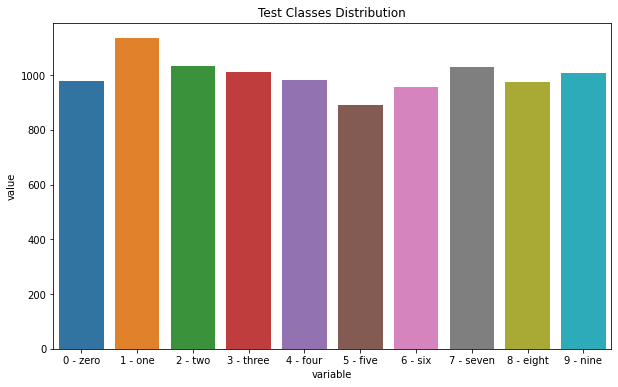

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_data)]).melt(),
            x = "variable", y="value").set_title('Test Classes Distribution')

In [8]:
train_data, val_data = t.utils.data.random_split(train_data, [50000, 10000])
print(len(train_data),len(val_data))


50000 10000


Text(0.5, 1.0, 'Train Classes Distribution')

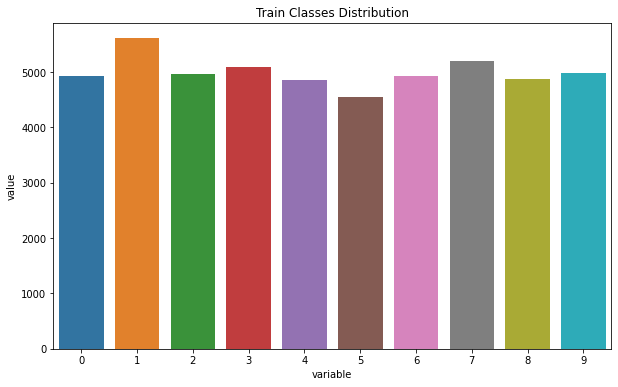

In [10]:
from collections import Counter
plt.figure(figsize=(10,6))
sns.barplot(data = pd.DataFrame.from_dict([Counter([label for _, label in train_data])]).melt(),
            x = "variable", y="value").set_title('Train Classes Distribution')

Text(0.5, 1.0, 'Val Classes Distribution')

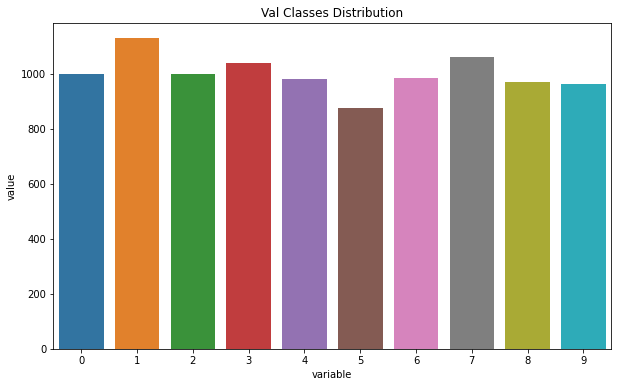

In [11]:
from collections import Counter
plt.figure(figsize=(10,6))
sns.barplot(data = pd.DataFrame.from_dict([Counter([label for _, label in val_data])]).melt(),
            x = "variable", y="value").set_title('Val Classes Distribution')


In [12]:
train_loader = t.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train, shuffle=True)

test_loader = t.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test, shuffle=True)

val_loader = t.utils.data.DataLoader(
    val_data,
    batch_size=batch_size_test, shuffle=True)

In [13]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
device

device(type='cuda')

#Models

In [14]:
class FCNet(nn.Module):
    def __init__(self, n_embedded = 256):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(784, n_embedded),
            nn.ReLU(),
            nn.Linear(n_embedded, n_embedded//2),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(n_embedded//2, 10)
        )

    def forward(self, x):
        x = self.layer(x)
        x = self.classifier(x)
        return x

In [15]:
from torch.nn.modules.activation import ReLU
class AECls(nn.Module):
    def __init__(self, n_embedded = 256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, n_embedded),
            nn.ReLU(),
            nn.Linear(n_embedded, n_embedded//2),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_embedded//2, n_embedded),
            nn.ReLU(),
            nn.Linear(n_embedded, 784)
        )

        self.classifier = nn.Sequential(
            nn.Linear(n_embedded//2, 10)
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(n_embedded//2, 10)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        cls = self.classifier(encoded)
        cls2 = self.classifier2(encoded)
        return decoded, cls, cls2

#AE -> classifier (учим только последний слой)

In [16]:
model = AECls().to(device)
# print(model)

In [17]:
model

AECls(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier2): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
summary(model, (1,784), 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [1, 1, 256]         200,960
              ReLU-2                [1, 1, 256]               0
            Linear-3                [1, 1, 128]          32,896
              ReLU-4                [1, 1, 128]               0
            Linear-5                [1, 1, 256]          33,024
              ReLU-6                [1, 1, 256]               0
            Linear-7                [1, 1, 784]         201,488
            Linear-8                 [1, 1, 10]           1,290
            Linear-9                 [1, 1, 10]           1,290
Total params: 470,948
Trainable params: 470,948
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.80
Estimated Total Size (MB): 1.82
-------------------------------------------

In [ ]:
params_AE = list(model.encoder.parameters()) + list(model.decoder.parameters()) # передаем данные веса для обучения AutoEncoder целиком
param_cls = list(model.classifier.parameters()) # Передаем данные веса для обучения последнего слоя, отвечающего за классификацию на основе фичей полученных с энкодера

In [ ]:
optimizer = optim.Adam(params_AE, lr=1e-3)# обучение кодирование декодирования
criterion = nn.MSELoss()

In [ ]:
def train(model, some_loader): # for AE
    # for epoch in range(epochs):
    loss = 0
    for input, _ in some_loader:
        input = input.view(-1, 784).to(device)

        optimizer.zero_grad()
        
        outputs, _, _ = model(input)

        train_loss = criterion(outputs, input)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(some_loader)
    
    # print(f"epoch : {epoch + 1}/{epochs}, loss = {loss}")
    return loss

In [ ]:
def evaluate(model, some_loader): # for AE
    loss = 0
    for input, _ in some_loader:
        input = input.view(-1, 784).to(device)
        with t.no_grad():
            optimizer.zero_grad()
            
            outputs, _, _ = model(input)

            train_loss = criterion(outputs, input)
        
        # train_loss.backward()
        
        # optimizer.step()
        
            loss += train_loss.item()
    
    loss = loss / len(some_loader)
    
    # print(f"epoch : {epoch + 1}/{epochs}, loss = {loss}")
    return loss

In [ ]:
tl_fae, vl_fae = [], [] # change to view vl_cae_cls1 
tmp_loss = float('inf')
for epoch in range(epochs):
    print('\nEpoch {:} / {:}'.format(epoch + 1, epochs)+' ################')
    train_loss = train(model, train_loader)
    val_loss = evaluate(model, val_loader)
    if val_loss < tmp_loss:
        tmp_loss = val_loss
        t.save(model.state_dict(), '/content/drive/MyDrive/AutoEncoders/' + 'fae' + '.pt')
        t.save(model.state_dict(),'fae' + '.pt')
        print(epoch+1)
    tl_fae.append(train_loss)
    vl_fae.append(val_loss)
    print(f'    train loss: {train_loss}, val loss: {val_loss}')


Epoch 1 / 30 ################
1
    train loss: 0.251278723139897, val loss: 0.13347827463964873

Epoch 2 / 30 ################
2
    train loss: 0.11254387141188697, val loss: 0.09938583579621738

Epoch 3 / 30 ################
3
    train loss: 0.09301098468511002, val loss: 0.09270303498340558

Epoch 4 / 30 ################
4
    train loss: 0.08359442712248438, val loss: 0.0805555266104167

Epoch 5 / 30 ################
5
    train loss: 0.07785412114675698, val loss: 0.07531754776269575

Epoch 6 / 30 ################
6
    train loss: 0.07454959200242596, val loss: 0.07379565887813326

Epoch 7 / 30 ################
7
    train loss: 0.07301928851839222, val loss: 0.07212833899863158

Epoch 8 / 30 ################
    train loss: 0.07242194103920246, val loss: 0.07263049445574797

Epoch 9 / 30 ################
9
    train loss: 0.07198024779329519, val loss: 0.07148519846834714

Epoch 10 / 30 ################
10
    train loss: 0.07155045560177635, val loss: 0.07079017068011852

Ep

In [ ]:
model.load_state_dict(t.load('/content/fae.pt')) #/content/drive/MyDrive/AutoEncoders/fae.pt   /content/fae.pt

<All keys matched successfully>

In [ ]:
optimizer = optim.Adam(param_cls, lr=1e-3) # последний слой, отвечающий за классификацию
criterion = t.nn.CrossEntropyLoss()

In [36]:
path_for_save_model = '/content/drive/MyDrive/AutoEncoders/'

In [ ]:
def train_cls(model, some_train_loader, some_val_loader, aug=False):
    """return list of train loss and list of val loss"""
    best_valid_loss = float('inf')
    ae_cls_train, ae_cls_val = [], []
    for epoch in range(epochs):
        loss_t, loss_c = 0, 0
        for input, labels in some_train_loader:
            # reshape mini-batch data to [N, 784] matrix
            # load it to the active device
            input, labels = input.view(-1, 784).to(device), labels.to(device)
            
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            
            # compute reconstructions
            _, outputs, _ = model(input)
            # compute training reconstruction loss
            train_loss = criterion(outputs, labels)
            
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss_t += train_loss.item()
        
        # compute the epoch training loss
        loss_t = loss_t / len(some_train_loader)
        ae_cls_train.append(loss_t)

        for input, labels in some_val_loader:
            input, labels = input.view(-1, 784).to(device), labels.to(device)
            with t.no_grad():
                optimizer.zero_grad()
                
                _, outputs, _ = model(input)

                val_loss = criterion(outputs, labels)
                loss_c += val_loss.item()
        
        loss_c = loss_c / len(some_val_loader)
        if loss_c < best_valid_loss and not aug:
            best_valid_loss = loss_c
            t.save(model.state_dict(),path_for_save_model + 'fae_cls1' + '.pt')
            t.save(model.state_dict(),'fae_cls1' + '.pt')
            print(epoch+1)
        elif loss_c < best_valid_loss and aug:
            best_valid_loss = loss_c
            t.save(model.state_dict(),path_for_save_model + 'aug_fae_cls1' + '.pt')
            t.save(model.state_dict(),'aug_fae_cls1' + '.pt')
            print(epoch+1)
        ae_cls_val.append(loss_c)
        
        # display the epoch training loss
        print(f"epoch : {epoch + 1}/{epochs}\n    loss train = {loss_t}, loss val = {loss_c}")
    return ae_cls_train, ae_cls_val

In [ ]:
tl_fae_cls1, vl_fae_cls1 = train_cls(model, train_loader, val_loader) # change to view vl_cae_cls1

1
epoch : 1/30
    loss train = 1.0124015005500726, loss val = 0.5961416220363183
2
epoch : 2/30
    loss train = 0.5058551756164912, loss val = 0.4601675000371812
3
epoch : 3/30
    loss train = 0.42122920036620803, loss val = 0.40959307174139387
4
epoch : 4/30
    loss train = 0.38504632457595345, loss val = 0.3818569249367412
5
epoch : 5/30
    loss train = 0.3633094717703207, loss val = 0.3674948394675798
6
epoch : 6/30
    loss train = 0.3482482189793721, loss val = 0.3617047371366356
7
epoch : 7/30
    loss train = 0.33864378784318716, loss val = 0.34849244186395334
8
epoch : 8/30
    loss train = 0.3299848371378296, loss val = 0.3396745369404177
epoch : 9/30
    loss train = 0.32410030890151365, loss val = 0.3398196651965757
10
epoch : 10/30
    loss train = 0.320355613022814, loss val = 0.3378083156068114
11
epoch : 11/30
    loss train = 0.31608606711068116, loss val = 0.3305150336479839
12
epoch : 12/30
    loss train = 0.31363719606491003, loss val = 0.32996372878551483
13
e

In [ ]:
model.load_state_dict(t.load('/content/fae_cls1.pt'))

<All keys matched successfully>

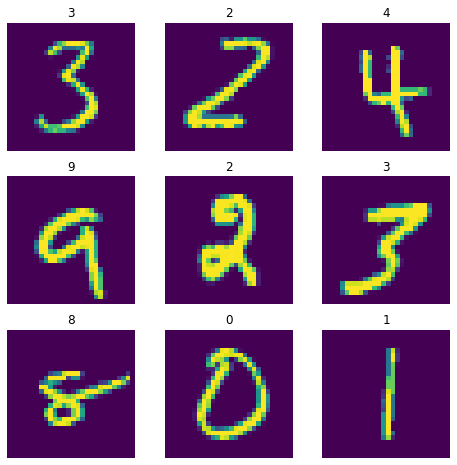

In [ ]:
figure = plt.figure(figsize=(8, 8))
for_pred = []

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = t.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())#, cmap="gray")

    for_pred.append(sample_idx) 
plt.show()

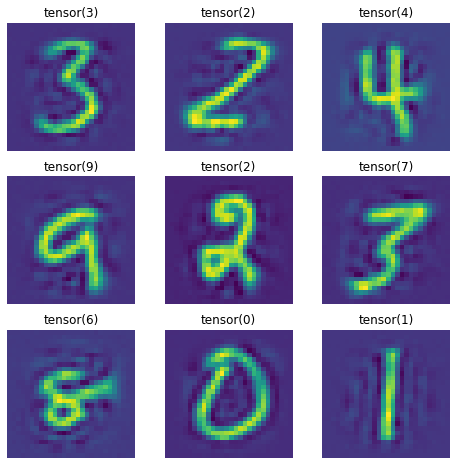

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # print(test_data[for_pred[i]][0][0].shape)
    img, label,_ = model(test_data[for_pred[i-1]][0][0].view(-1,784))
    img = img.detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.title(t.argmax(label))
    plt.axis("off")
    plt.imshow(img.reshape(28,28)) #, cmap="gray")

plt.show()

In [43]:
def get_true_tst():
    y_treu_tst = []
    for item in test_data:
        y_treu_tst.append(item[1])
    return y_treu_tst

In [44]:
def get_pred_tst(model, ae = True, f=False):
    y_pred_tst = []
    for data, label in test_data:
        data = data.to(device)
        if ae:
            _, label, _ = model(data.view(-1,784).detach())
            if not f:
                 _, _, label = model(data.view(-1,784))
        else:
            label = model(data.view(-1,784))
        y_pred_tst.append(int(t.argmax(label)))
    return y_pred_tst

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
true, pred = get_true_tst(), get_pred_tst(model, f =True)
print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

micro: 0.9169
macro: 0.9156202015568331
accuracy: 0.9169


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.89      0.91      0.90      1010
           4       0.93      0.92      0.92       982
           5       0.89      0.86      0.88       892
           6       0.92      0.95      0.94       958
           7       0.93      0.92      0.92      1028
           8       0.90      0.85      0.87       974
           9       0.87      0.91      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



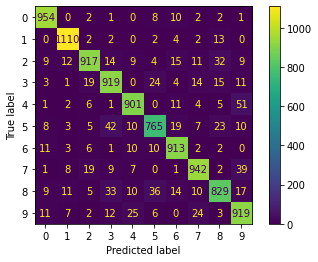

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
true, pred = get_true_tst(), get_pred_tst(model, f =True)
print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))

#AE -> classifier (учим encoder и classifier)

In [ ]:
params_EnCl = list(model.encoder.parameters()) + list(model.classifier2.parameters()) # переучиваем encoder и слой для классификации (encoder уже обучался на этих данных для AE)
optimizer = optim.Adam(params_EnCl, lr=1e-3)
criterion = t.nn.CrossEntropyLoss()

In [ ]:
def train_enc_cls(model, some_train_loader, some_val_loader, aug=False):
    """return lists of train and val losses"""
    best_valid_loss = float('inf')
    nae_cls_train, nae_cls_val = [], []
    for epoch in range(epochs):
        loss_t, loss_c = 0, 0
        for input, labels in some_train_loader:
            # reshape mini-batch data to [N, 784] matrix
            # load it to the active device
            input, labels = input.view(-1, 784).to(device), labels.to(device)
            
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            
            # compute reconstructions
            _, _, outputs = model(input)
            # compute training reconstruction loss
            train_loss = criterion(outputs, labels)
            
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss_t += train_loss.item()
        
        # compute the epoch training loss
        loss_t = loss_t / len(some_train_loader)
        nae_cls_train.append(loss_t)

        for input, labels in some_val_loader:
            input, labels = input.view(-1, 784).to(device), labels.to(device)
            with t.no_grad():
                optimizer.zero_grad()
                
                _, _, outputs = model(input)

                val_loss = criterion(outputs, labels)
                loss_c += val_loss.item()
        
        loss_c = loss_c / len(some_val_loader)
        if loss_c < best_valid_loss and not aug:
            best_valid_loss = loss_c
            t.save(model.state_dict(),path_for_save_model + 'fae_cls2' + '.pt')
            t.save(model.state_dict(),'fae_cls2' + '.pt')
            print(epoch+1)
        elif loss_c < best_valid_loss and aug:
            best_valid_loss = loss_c
            t.save(model.state_dict(),path_for_save_model + 'aug_fae_cls2' + '.pt')
            t.save(model.state_dict(),'aug_fae_cls2' + '.pt')
            print(epoch+1)
        nae_cls_val.append(loss_c)
        
        # display the epoch training loss
        print(f"epoch : {epoch + 1}/{epochs}\n    loss train = {loss_t}, loss val = {loss_c}")
    return nae_cls_train, nae_cls_val

In [ ]:
tl_fae_cls2, vl_fae_cls2 = train_enc_cls(model, train_loader, val_loader)

1
epoch : 1/30
    loss train = 0.3682201248033882, loss val = 0.20456169545650482
2
epoch : 2/30
    loss train = 0.14995129490295028, loss val = 0.13582338843070255
3
epoch : 3/30
    loss train = 0.09723395836132262, loss val = 0.10958439432367494
4
epoch : 4/30
    loss train = 0.07073330049357755, loss val = 0.09619239713006382
epoch : 5/30
    loss train = 0.0535449986298428, loss val = 0.10245039417184418
6
epoch : 6/30
    loss train = 0.04041610984369884, loss val = 0.08990555124569542
7
epoch : 7/30
    loss train = 0.03150534105148938, loss val = 0.08686352214669879
epoch : 8/30
    loss train = 0.025614626310251253, loss val = 0.08852156983759207
epoch : 9/30
    loss train = 0.021468752968337033, loss val = 0.10374401320844795
epoch : 10/30
    loss train = 0.019875739235430956, loss val = 0.10326335205052924
epoch : 11/30
    loss train = 0.021126087589273968, loss val = 0.10621947549059516
epoch : 12/30
    loss train = 0.01501692544854701, loss val = 0.10426379336763315

In [ ]:
model.load_state_dict(t.load('/content/fae_cls2.pt')) #/content/drive/MyDrive/AutoEncoders/fae_cls12.pt  /content/fae_cls2.pt

<All keys matched successfully>

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
true, pred = get_true_tst(), get_pred_tst(model)
print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

micro: 0.9775
macro: 0.9773937275488442
accuracy: 0.9775


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.97       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.94      0.98      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



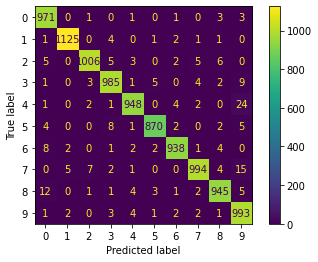

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
true, pred = get_true_tst(), get_pred_tst(model)
print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))

#FCNet

In [ ]:
fcnet = FCNet().to(device)

In [ ]:
optimizer = optim.Adam(fcnet.parameters(), lr=1e-3)
criterion = t.nn.CrossEntropyLoss()

In [ ]:
def train_FC(model, some_train_loader, some_val_loader, aug= False):
    fc_train_loss, fc_val_loss = [], []
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        loss_t = 0
        loss_v = 0
        for input, target in some_train_loader:
            input, target = input.view(-1, 784).to(device), target.to(device)

            optimizer.zero_grad()
            
            outputs = model(input)
            train_loss = criterion(outputs, target)
            
            train_loss.backward()
            
            optimizer.step()
            
            loss_t += train_loss.item()
        
        loss_t = loss_t / len(some_train_loader)

        for input, labels in some_val_loader:
            input, labels = input.view(-1, 784).to(device), labels.to(device)

            with t.no_grad():
                optimizer.zero_grad()
                
                outputs = model(input)

                loss_v = criterion(outputs, labels)
                loss_v += loss_v.item()
        
        loss_v = loss_v / len(some_val_loader)
        if loss_v < best_valid_loss and not aug:
            best_valid_loss = loss_v
            t.save(model.state_dict(),path_for_save_model + 'fcn_cls3' + '.pt')
            t.save(model.state_dict(),'fcn_cls3' + '.pt')
            print(epoch+1)
        elif loss_v < best_valid_loss and aug:
            best_valid_loss = loss_v
            t.save(model.state_dict(),path_for_save_model + 'aug_fcn_cls3' + '.pt')
            t.save(model.state_dict(),'aug_fcn_cls3' + '.pt')
            print(epoch+1)
        fc_val_loss.append(loss_v)
        
        print(f"epoch : {epoch + 1}/{epochs}, train loss = {loss_t}, val loss = {loss_v}")
    return fc_train_loss, fc_val_loss

In [ ]:
tl_fae_cls3, vl_fae_cls3 = train_FC(fcnet, train_loader, val_loader)

1
epoch : 1/30, train loss = 0.2877407371330902, val loss = 0.011911693960428238
2
epoch : 2/30, train loss = 0.10762930690499066, val loss = 0.011743822135031223
3
epoch : 3/30, train loss = 0.07330012465338878, val loss = 0.0012202325742691755
epoch : 4/30, train loss = 0.05191028036553499, val loss = 0.0023040289524942636
5
epoch : 5/30, train loss = 0.039820808390884296, val loss = 0.00017275165009777993
epoch : 6/30, train loss = 0.03289685612115675, val loss = 0.000248256663326174
epoch : 7/30, train loss = 0.024139267755696154, val loss = 0.009711895138025284
epoch : 8/30, train loss = 0.025097065800241174, val loss = 0.008379373699426651
epoch : 9/30, train loss = 0.018982150125801994, val loss = 0.00903811864554882
epoch : 10/30, train loss = 0.017611522164107645, val loss = 0.005946039222180843
epoch : 11/30, train loss = 0.01701928701665898, val loss = 0.0003590261621866375
epoch : 12/30, train loss = 0.015925910626508326, val loss = 0.006820721086114645
13
epoch : 13/30, tr

In [ ]:
fcnet.load_state_dict(t.load('/content/fcn_cls3.pt'))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
true, pred = get_true_tst(), get_pred_tst(fcnet, False, True)
print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

micro: 0.978
macro: 0.9777683191900884
accuracy: 0.978


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.99      0.95      0.97       982
           5       0.98      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.95      0.97       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



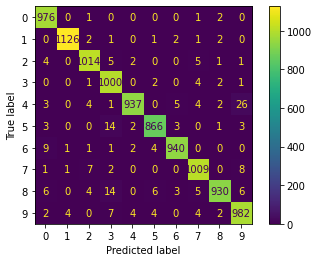

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
true, pred = get_true_tst(), get_pred_tst(fcnet, False, True)
print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))

In [ ]:
def PlotVal(val1,val2,val3, name1 = 'last fc layer', name2='encoder+fc', name3='fc net'):
    x = range(30)
    plt.plot(x, val1, label = name1)
    plt.plot(x, val2, label = name2)
    plt.plot(x, val3, label = name3)
    plt.xlabel('epoch')
    plt.ylabel('val loss')
    plt.legend()
    plt.show()

# PlotVal(vl_fae_cls1, vl_fae_cls2, vl_fae_cls3)

# Добавление аугментаций 

In [18]:
tranforms_second = torchvision.transforms.Compose([
                               torchvision.transforms.RandomErasing(p=1, scale=(0.1, 0.15))]
                               )

In [19]:
class DatasetCustom(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset) 

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transforms:
            img = self.transforms(img)

        return img, label

In [20]:
aug_train_data = DatasetCustom(train_data, tranforms_second)
aug_val_data = DatasetCustom(val_data)
aug_test_data = DatasetCustom(test_data)

In [21]:
aug_train_loader = t.utils.data.DataLoader(
    aug_train_data,
    batch_size=batch_size_train, shuffle=True)

aug_test_loader = t.utils.data.DataLoader(
    aug_test_data,
    batch_size=batch_size_test, shuffle=True)

aug_val_loader = t.utils.data.DataLoader(
    aug_val_data,
    batch_size=batch_size_test, shuffle=True)

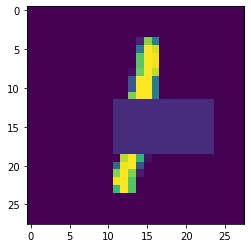

In [22]:
plt.imshow(aug_train_data[6][0][0])

In [23]:
aug_train_data[6][1]

1

In [24]:
aug_model = AECls().to(device)

In [25]:
params_aug_AE = list(aug_model.encoder.parameters()) + list(aug_model.decoder.parameters()) # передаем данные веса для обучения AutoEncoder целиком
optimizer = optim.Adam(params_aug_AE, lr=1e-3)# обучение кодирование декодирования
criterion = nn.MSELoss()

In [ ]:
aug_ae_train_loss, aug_ae_val_loss = [], []
tmp_loss = float('inf')
for epoch in range(epochs):
    print('\nEpoch {:} / {:}'.format(epoch + 1, epochs)+' ################')
    train_loss = train(aug_model, aug_train_loader)
    val_loss = evaluate(aug_model, aug_val_loader)
    if val_loss < tmp_loss:
        tmp_loss = val_loss
        t.save(aug_model.state_dict(), '/content/drive/MyDrive/AutoEncoders/' + 'aug_fae' + '.pt')
        t.save(aug_model.state_dict(),'aug_fae' + '.pt')
        print(epoch+1)
    aug_ae_train_loss.append(train_loss)
    aug_ae_val_loss.append(val_loss)
    print(f'    train loss: {train_loss}, val loss: {val_loss}')


Epoch 1 / 30 ################
1
    train loss: 0.22035493564499004, val loss: 0.12592719749936573

Epoch 2 / 30 ################
2
    train loss: 0.10689097214156709, val loss: 0.09460312995729567

Epoch 3 / 30 ################
3
    train loss: 0.08894268941620122, val loss: 0.08340506934666936

Epoch 4 / 30 ################
4
    train loss: 0.08107103439776794, val loss: 0.07760464843315414

Epoch 5 / 30 ################
5
    train loss: 0.07724625657281607, val loss: 0.07465604126830644

Epoch 6 / 30 ################
6
    train loss: 0.07540011224920487, val loss: 0.07458171116400368

Epoch 7 / 30 ################
7
    train loss: 0.07477102243839323, val loss: 0.07398577704082561

Epoch 8 / 30 ################
8
    train loss: 0.0741486928575789, val loss: 0.07254839782850651

Epoch 9 / 30 ################
    train loss: 0.07405526718825026, val loss: 0.07259841763143297

Epoch 10 / 30 ################
10
    train loss: 0.07381695070687462, val loss: 0.07188274730232698



In [27]:
aug_model.load_state_dict(t.load('/content/drive/MyDrive/AutoEncoders/aug_fae.pt'))

<All keys matched successfully>

#AE -> classifier (учим только последний слой)

In [ ]:
aug_param_cls = list(aug_model.classifier.parameters()) # Передаем данные веса для обучения последнего слоя, отвечающего за классификацию на основе фичей полученных с энкодера
optimizer = optim.Adam(aug_param_cls, lr=1e-3)# обучение кодирование декодирования
criterion = nn.CrossEntropyLoss()

In [ ]:
tl_augfae_cls1, vl_augfae_cls1 = train_cls(aug_model,aug_train_loader, aug_val_loader, True)

1
epoch : 1/30
    loss train = 0.5672477885432865, loss val = 0.4042490020960192
2
epoch : 2/30
    loss train = 0.5520480943610296, loss val = 0.40258396501782573
3
epoch : 3/30
    loss train = 0.5494955358145487, loss val = 0.3947378323425221
4
epoch : 4/30
    loss train = 0.5450477310458718, loss val = 0.385216511125806
epoch : 5/30
    loss train = 0.533038592628201, loss val = 0.38547516152074063
epoch : 6/30
    loss train = 0.5355076663329473, loss val = 0.38927093789547307
epoch : 7/30
    loss train = 0.5282328830045813, loss val = 0.3922278948977024
8
epoch : 8/30
    loss train = 0.5311896920661487, loss val = 0.38188022337382355
9
epoch : 9/30
    loss train = 0.52820630314405, loss val = 0.38024536906918394
10
epoch : 10/30
    loss train = 0.5273331498246059, loss val = 0.3793977643304233
11
epoch : 11/30
    loss train = 0.5230914371855119, loss val = 0.3708411564791127
epoch : 12/30
    loss train = 0.5247822463359979, loss val = 0.37782516736018507
epoch : 13/30
   

In [ ]:
aug_model.load_state_dict(t.load('/content/aug_fae_cls1.pt'))

<All keys matched successfully>

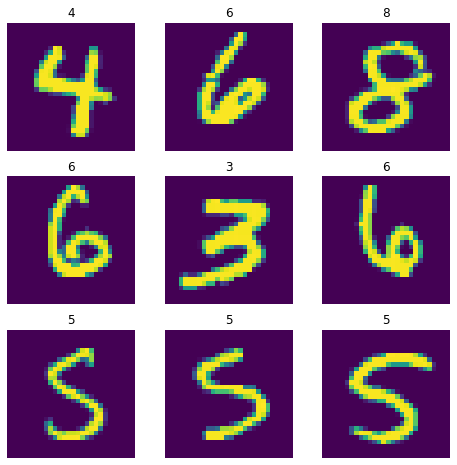

In [ ]:
figure = plt.figure(figsize=(8, 8))
for_pred1 = []

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = t.randint(len(test_data), size=(1,)).item()
    img, label = aug_test_data[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())#, cmap="gray")

    for_pred1.append(sample_idx) 
plt.show()

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # print(test_data[for_pred[i]][0][0].shape)
    img, label,_ = aug_model(aug_test_data[for_pred1[i-1]][0][0].view(-1,784))
    img = img.detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.title(t.argmax(label))
    plt.axis("off")
    plt.imshow(img.reshape(28,28)) #, cmap="gray")

plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
true, pred = get_true_tst(), get_pred_tst(aug_model, f =True)
print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

micro: 0.9057
macro: 0.9043579778986695
accuracy: 0.9057


              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.94      0.97      0.95      1135
           2       0.91      0.87      0.89      1032
           3       0.92      0.87      0.90      1010
           4       0.88      0.92      0.90       982
           5       0.91      0.82      0.86       892
           6       0.90      0.94      0.92       958
           7       0.90      0.91      0.91      1028
           8       0.84      0.89      0.86       974
           9       0.90      0.87      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000



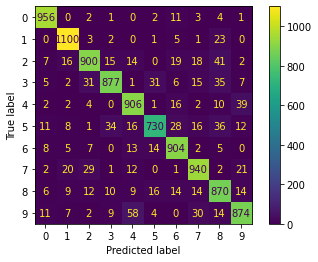

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
true, pred = get_true_tst(), get_pred_tst(aug_model, f =True)
print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))

#AE -> classifier (учим encoder и classifier)

In [ ]:
params_EnCl = list(aug_model.encoder.parameters()) + list(aug_model.classifier2.parameters()) # переучиваем encoder и слой для классификации (encoder уже обучался на этих данных для AE)
optimizer = optim.Adam(params_EnCl, lr=1e-3)
criterion = t.nn.CrossEntropyLoss()

In [ ]:
tl_augfae_cls2, vl_augfae_cls2 = train_enc_cls(aug_model, aug_train_loader, aug_val_loader, True)

1
epoch : 1/30
    loss train = 0.5753522242426568, loss val = 0.25641689798499967
2
epoch : 2/30
    loss train = 0.31100454486315815, loss val = 0.1657786753170098
3
epoch : 3/30
    loss train = 0.2304703978359547, loss val = 0.13249025682482538
4
epoch : 4/30
    loss train = 0.19038777927989545, loss val = 0.1110206174935344
5
epoch : 5/30
    loss train = 0.17045217064564186, loss val = 0.09252636339751226
6
epoch : 6/30
    loss train = 0.1520870971633955, loss val = 0.08902583863067476
7
epoch : 7/30
    loss train = 0.14387377277207192, loss val = 0.0835603753317006
epoch : 8/30
    loss train = 0.1297841760356103, loss val = 0.08595701728363911
epoch : 9/30
    loss train = 0.12973182924720636, loss val = 0.08386979174882739
10
epoch : 10/30
    loss train = 0.12224462084338793, loss val = 0.07330832569535728
11
epoch : 11/30
    loss train = 0.11720900693932153, loss val = 0.06666332204484299
epoch : 12/30
    loss train = 0.11074622044973362, loss val = 0.07365634818148764


In [ ]:
aug_model.load_state_dict(t.load('/content/aug_fae_cls2.pt'))

<All keys matched successfully>

micro: 0.9824
macro: 0.982324731388864
accuracy: 0.9824
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



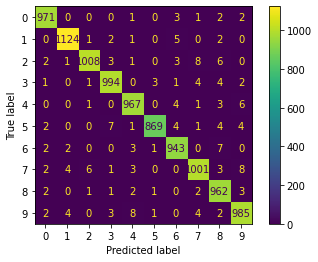

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

true, pred = get_true_tst(), get_pred_tst(aug_model)

print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))


#FCNet

In [ ]:
aug_fc = FCNet().to(device)

In [ ]:
optimizer = optim.Adam(aug_fc.parameters(), lr=1e-3)
criterion = t.nn.CrossEntropyLoss()

In [ ]:
tl_augfae_cls3, vl_augfae_cls3 = train_FC(aug_fc,aug_train_loader, aug_val_loader, True)

1
epoch : 1/30, train loss = 0.46994973547623287, val loss = 0.0031361214350908995
epoch : 2/30, train loss = 0.24107429011703452, val loss = 0.01020016148686409
3
epoch : 3/30, train loss = 0.19147003328670625, val loss = 0.0009754541097208858
epoch : 4/30, train loss = 0.16832465217317766, val loss = 0.009382057934999466
5
epoch : 5/30, train loss = 0.14731011434894084, val loss = 6.055817357264459e-05
6
epoch : 6/30, train loss = 0.14066629022207405, val loss = 2.8046046281815507e-05
epoch : 7/30, train loss = 0.12877468554222066, val loss = 0.0015577982412651181
epoch : 8/30, train loss = 0.12741206028520147, val loss = 0.0001879366027424112
9
epoch : 9/30, train loss = 0.12251588617882612, val loss = 4.487932528718375e-06
epoch : 10/30, train loss = 0.11533286820744615, val loss = 0.00017719964671414346
epoch : 11/30, train loss = 0.10720036291729307, val loss = 0.00013581958774011582
epoch : 12/30, train loss = 0.105730200181608, val loss = 6.961120561754797e-06
epoch : 13/30, tr

In [ ]:
aug_fc.load_state_dict(t.load('/content/aug_fcn_cls3.pt'))

<All keys matched successfully>

micro: 0.9785
macro: 0.9784166636719757
accuracy: 0.9785
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



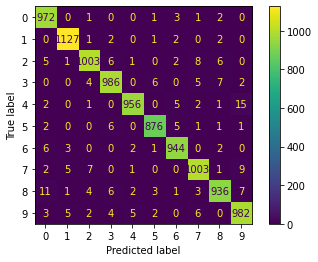

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
true, pred = get_true_tst(), get_pred_tst(aug_fc, False, True)
print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))

In [ ]:
vl_augfae_cls3 = [float(item) for item in vl_augfae_cls3]

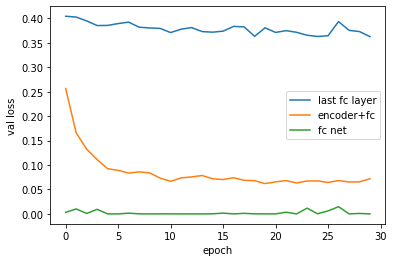

In [ ]:
PlotVal(vl_augfae_cls1, vl_augfae_cls2, vl_augfae_cls3)

#Conv

In [29]:
class CN_AE(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 8, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(8, 16, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(16, 4, 3, padding=1),
                nn.ReLU()
                
        )

        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(4, 16, 3, stride=1, padding=1),
                nn.ReLU(),

                nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1),
                nn.ReLU(),

                nn.ConvTranspose2d(8, 1, 4, stride=2, padding=0),
                

                # nn.ConvTranspose2d(16, 8, 3, stride=1, padding=1)
        )

        self.classifier1 = nn.Sequential(
            nn.Linear(196, 10),
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(196, 10),
        )

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = t.flatten(encoded, 1)
        cls = self.classifier1(encoded)
        cls2 = self.classifier2(encoded)
        return decoded, cls, cls2


In [30]:
cn_AE = CN_AE().to(device)
summary(cn_AE, (1,28,28),1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 8, 28, 28]              80
              ReLU-2             [1, 8, 28, 28]               0
         MaxPool2d-3             [1, 8, 14, 14]               0
            Conv2d-4            [1, 16, 14, 14]           1,168
              ReLU-5            [1, 16, 14, 14]               0
         MaxPool2d-6              [1, 16, 7, 7]               0
            Conv2d-7               [1, 4, 7, 7]             580
              ReLU-8               [1, 4, 7, 7]               0
   ConvTranspose2d-9              [1, 16, 7, 7]             592
             ReLU-10              [1, 16, 7, 7]               0
  ConvTranspose2d-11             [1, 8, 13, 13]           1,160
             ReLU-12             [1, 8, 13, 13]               0
  ConvTranspose2d-13             [1, 1, 28, 28]             129
           Linear-14                   

In [ ]:
params_CAE = list(cn_AE.encoder.parameters()) + list(cn_AE.decoder.parameters())

In [ ]:
optimizer = optim.Adam(params_CAE, lr=1e-3)# обучение кодирование декодирования
criterion = nn.MSELoss()

In [ ]:
def conv_train(model, some_loader): # for AE
    loss = 0
    for input, _ in some_loader:
        input = input.to(device)
        optimizer.zero_grad()
        
        outputs, _, _ = model(input)

        train_loss = criterion(outputs, input)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(some_loader)
    
    # print(f"epoch : {epoch + 1}/{epochs}, loss = {loss}")
    return loss

def conv_evaluate(model, some_loader): # for AE
    loss = 0
    for input, _ in some_loader:
        with t.no_grad():
            input = input.to(device)
            optimizer.zero_grad()
            
            outputs, _, _ = model(input)

            train_loss = criterion(outputs, input)
        
        
            loss += train_loss.item()
    
    loss = loss / len(some_loader)
    
    # print(f"epoch : {epoch + 1}/{epochs}, loss = {loss}")
    return loss

In [ ]:
tl_сae, vl_сae = [], [] # change to view vl_cae_cls1 
tmp_loss = float('inf')
for epoch in range(epochs):
    print('\nEpoch {:} / {:}'.format(epoch + 1, epochs)+' ################')
    train_loss = conv_train(cn_AE, train_loader)
    val_loss = conv_evaluate(cn_AE, val_loader)
    if val_loss < tmp_loss:
        tmp_loss = val_loss
        t.save(cn_AE.state_dict(), '/content/drive/MyDrive/AutoEncoders/' + 'ConvAE' + '.pt')
        t.save(cn_AE.state_dict(),'ConvAE' + '.pt')
        print(epoch+1)
    tl_сae.append(train_loss)
    vl_сae.append(val_loss)
    print(f'    train loss: {train_loss}, val loss: {val_loss}')


Epoch 1 / 30 ################
1
    train loss: 0.3324320774782649, val loss: 0.13170780892236322

Epoch 2 / 30 ################
2
    train loss: 0.10854965177795771, val loss: 0.09287388217222842

Epoch 3 / 30 ################
3
    train loss: 0.08541395547597305, val loss: 0.07877843506351302

Epoch 4 / 30 ################
4
    train loss: 0.07424661301819564, val loss: 0.07034161677466164

Epoch 5 / 30 ################
5
    train loss: 0.06703838599307457, val loss: 0.06434271192248864

Epoch 6 / 30 ################
6
    train loss: 0.061985895047178656, val loss: 0.05945980402676365

Epoch 7 / 30 ################
7
    train loss: 0.05831602111916103, val loss: 0.056581088825117185

Epoch 8 / 30 ################
8
    train loss: 0.05530010028492154, val loss: 0.053662099651520766

Epoch 9 / 30 ################
9
    train loss: 0.052914200383988794, val loss: 0.0515211636224125

Epoch 10 / 30 ################
10
    train loss: 0.05088104522022445, val loss: 0.05008861158467

In [ ]:
out, _, _ = cn_AE(test_data[2][0].unsqueeze(0))

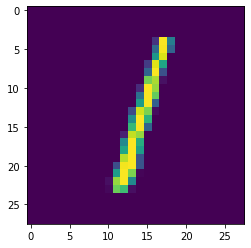

In [ ]:
plt.imshow(test_data[2][0][0])

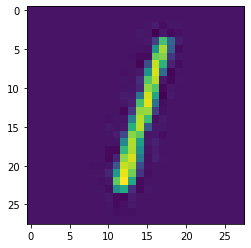

In [ ]:
plt.imshow(out[0][0].detach().numpy())

In [38]:
cn_AE.load_state_dict(t.load('/content/drive/MyDrive/AutoEncoders/ConvAE.pt'))

<All keys matched successfully>

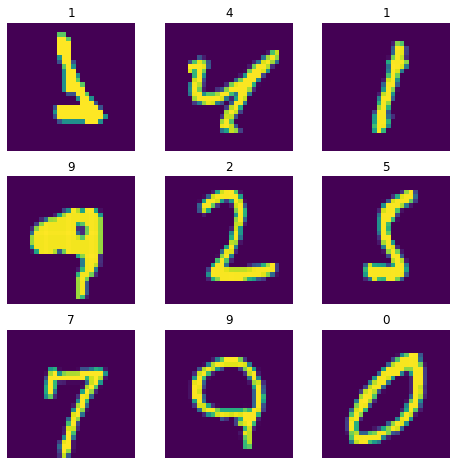

In [ ]:
figure = plt.figure(figsize=(8, 8))
for_pred = []

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = t.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())#, cmap="gray")

    for_pred.append(sample_idx) 
plt.show()

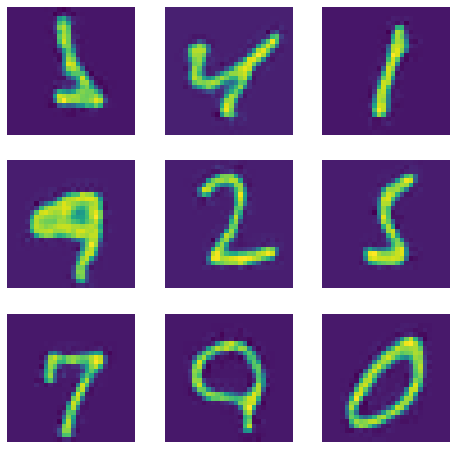

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, _, _ = cn_AE(test_data[for_pred[i-1]][0].unsqueeze(0))
    img = img.detach().numpy()
    figure.add_subplot(rows, cols, i)
    # plt.title(t.argmax(label))
    plt.axis("off")
    plt.imshow(img.reshape(28,28)) #, cmap="gray")

plt.show()

In [50]:
def get_pred_tst_cn(model, isFirst = True):
    y_pred_tst = []
    for data, label in test_data:
        data = data.to(device)
        if isFirst:
            _, label, _ = model(data.unsqueeze(0))
        else:
            _, _, label = model(data.unsqueeze(0))
        y_pred_tst.append(int(t.argmax(label)))
    return y_pred_tst

#Сверточынй AE-> classifier (учим последний слой)

In [34]:
def train_cls_cn(model, some_train_loader, some_val_loader, isFirst=True, aug=False):
    """return list of train loss and list of val loss"""
    ae_cls_train, ae_cls_val = [], []
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        loss_t, loss_c = 0, 0
        for input, labels in some_train_loader:
            input, labels = input.to(device), labels.to(device)
            # reshape mini-batch data to [N, 784] matrix
            # load it to the active device
            
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            
            # compute reconstructions
            if isFirst:
                _, outputs, _ = model(input)
            else:
                _, _, outputs = model(input)
            # compute training reconstruction loss
            train_loss = criterion(outputs, labels)
            
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss_t += train_loss.item()
        
        # compute the epoch training loss
        loss_t = loss_t / len(some_train_loader)
        ae_cls_train.append(loss_t)

        for input, labels in some_val_loader:
            with t.no_grad():
                input, labels = input.to(device), labels.to(device)
                optimizer.zero_grad()
                
                if isFirst:
                    _, outputs, _ = model(input)
                else:
                    _, _, outputs = model(input)

                val_loss = criterion(outputs, labels)
                loss_c += val_loss.item()
        
        loss_c = loss_c / len(some_val_loader)
        num = 1 if isFirst else 2
        if loss_c < best_valid_loss and not aug:
            best_valid_loss = loss_c
            t.save(model.state_dict(),path_for_save_model + 'ConvAE_cls' + str(num) + '.pt')
            t.save(model.state_dict(),'ConvAE_cls' + str(num) + '.pt')
            print(epoch+1)
        elif loss_c < best_valid_loss and aug:
            best_valid_loss = loss_c
            t.save(model.state_dict(),path_for_save_model + 'aug_ConvAE_cls' + str(num) + '.pt')
            t.save(model.state_dict(),'aug_ConvAE_cls' + str(num) + '.pt')
            print(epoch+1)
        ae_cls_val.append(loss_c)
        
        # display the epoch training loss
        print(f"epoch : {epoch + 1}/{epochs}\n    loss train = {loss_t}, loss val = {loss_c}")
    return ae_cls_train, ae_cls_val

In [ ]:
params_CAE_cls = list(cn_AE.classifier1.parameters())
optimizer = optim.Adam(params_CAE_cls, lr=1e-3)# обучение кодирование декодирования
criterion = nn.CrossEntropyLoss()

In [ ]:
tl_cae_cls1, vl_cae_cls1 = train_cls_cn(cn_AE, train_loader, val_loader)

1
epoch : 1/30
    loss train = 0.9144441616123594, loss val = 0.408714470606816
2
epoch : 2/30
    loss train = 0.3594670278565658, loss val = 0.3398310189382939
3
epoch : 3/30
    loss train = 0.3193149937464453, loss val = 0.3137894870736931
4
epoch : 4/30
    loss train = 0.2993323232816613, loss val = 0.2957892038776905
epoch : 5/30
    loss train = 0.28887871180272773, loss val = 0.3169334755290913
6
epoch : 6/30
    loss train = 0.27897890041703766, loss val = 0.2922216377492192
7
epoch : 7/30
    loss train = 0.27698194477564236, loss val = 0.2830348873062979
epoch : 8/30
    loss train = 0.268828221865932, loss val = 0.28426370562254627
9
epoch : 9/30
    loss train = 0.26303068289290304, loss val = 0.270752230022527
10
epoch : 10/30
    loss train = 0.2602237935947335, loss val = 0.267619897859006
epoch : 11/30
    loss train = 0.26023703527724956, loss val = 0.3011515159395677
epoch : 12/30
    loss train = 0.2586932387726996, loss val = 0.2714365351992317
epoch : 13/30
    

In [37]:
cn_AE.load_state_dict(t.load('/content/ConvAE_cls1.pt'))

FileNotFoundError: ignored

micro: 0.9364
macro: 0.9355679806211719
accuracy: 0.9364
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.93      0.92      0.92      1032
           3       0.92      0.91      0.92      1010
           4       0.95      0.93      0.94       982
           5       0.90      0.92      0.91       892
           6       0.95      0.95      0.95       958
           7       0.94      0.94      0.94      1028
           8       0.92      0.90      0.91       974
           9       0.91      0.93      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



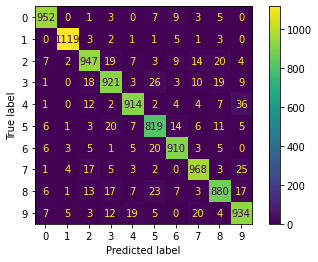

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

true, pred = get_true_tst(), get_pred_tst_cn(cn_AE)

print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))


#Сверточный AE-> classifier (учим pretrained encoder + classifier)

In [39]:
params_CAE_cls = list(cn_AE.encoder.parameters()) + list(cn_AE.classifier2.parameters())
optimizer = optim.Adam(params_CAE_cls, lr=1e-3)# обучение кодирование декодирования
criterion = nn.CrossEntropyLoss()

In [40]:
tl_cae_cls2, vl_cae_cls2 = train_cls_cn(cn_AE, train_loader, val_loader, False)

1
epoch : 1/30
    loss train = 0.8381542731886324, loss val = 0.32384388846687123
2
epoch : 2/30
    loss train = 0.23605085454900246, loss val = 0.19987022744703897
3
epoch : 3/30
    loss train = 0.1542890737609714, loss val = 0.13657467411477356
4
epoch : 4/30
    loss train = 0.11394763541648455, loss val = 0.1207387154521067
5
epoch : 5/30
    loss train = 0.09380008448201144, loss val = 0.09917672075142589
6
epoch : 6/30
    loss train = 0.08109224721541643, loss val = 0.09678488554833811
7
epoch : 7/30
    loss train = 0.07467235547378469, loss val = 0.08504880304577984
8
epoch : 8/30
    loss train = 0.06621553866392778, loss val = 0.07957058449429047
9
epoch : 9/30
    loss train = 0.06241599066406869, loss val = 0.07749873694456831
epoch : 10/30
    loss train = 0.0587611287055761, loss val = 0.07762330206762409
11
epoch : 11/30
    loss train = 0.05443172429300025, loss val = 0.06885192173686397
epoch : 12/30
    loss train = 0.05026355076371632, loss val = 0.07555611515299

In [41]:
cn_AE.load_state_dict(t.load('/content/ConvAE_cls2.pt'))

<All keys matched successfully>

micro: 0.9869
macro: 0.986808897706414
accuracy: 0.9869
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



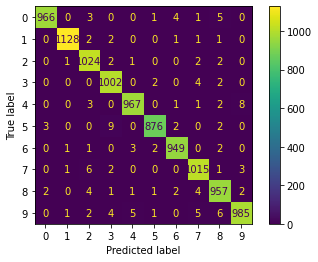

In [51]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

true, pred = get_true_tst(), get_pred_tst_cn(cn_AE, False)

print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))


#CNNet

In [ ]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 8, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(8, 16, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Conv2d(16, 4, 3, padding=1),
                nn.ReLU()
        )
        self.classifier1 = nn.Sequential(
            nn.Linear(196, 10),
        )

    def forward(self,x):
        encoded = self.encoder(x)
        encoded = t.flatten(encoded, 1)
        cls = self.classifier1(encoded)
        return cls


In [ ]:
cn_cl = CNNet().to(device)
optimizer = optim.Adam(cn_cl.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_cls_cn3(model, some_train_loader, some_val_loader, aug=False):
    """return list of train loss and list of val loss"""
    best_valid_loss = float('inf')
    ae_cls_train, ae_cls_val = [], []
    for epoch in range(epochs):
        loss_t, loss_c = 0, 0
        for input, labels in some_train_loader:
            input, labels = input.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(input)

            train_loss = criterion(outputs, labels)
            
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss_t += train_loss.item()
        
        # compute the epoch training loss
        loss_t = loss_t / len(some_train_loader)
        ae_cls_train.append(loss_t)

        for input, labels in some_val_loader:
            with t.no_grad():
                input, labels = input.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(input)

                val_loss = criterion(outputs, labels)
                loss_c += val_loss.item()
        
        loss_c = loss_c / len(some_val_loader)
        if loss_c < best_valid_loss and not aug:
            best_valid_loss = loss_c
            t.save(model.state_dict(),path_for_save_model + 'ConvAE_cls3' + '.pt')
            t.save(model.state_dict(),'ConvAE_cls3'  + '.pt')
            print(epoch+1)
        if loss_c < best_valid_loss and aug:
            best_valid_loss = loss_c
            t.save(model.state_dict(),path_for_save_model + 'aug_ConvAE_cls3'  + '.pt')
            t.save(model.state_dict(),'aug_ConvAE_cls3'  + '.pt')
            print(epoch+1)
        ae_cls_val.append(loss_c)
        
        # display the epoch training loss
        print(f"epoch : {epoch + 1}/{epochs}\n    loss train = {loss_t}, loss val = {loss_c}")
    return ae_cls_train, ae_cls_val

In [ ]:
tl_cae_cls3, vl_cae_cls3 = train_cls_cn3(cn_cl, train_loader, val_loader)

1
epoch : 1/30
    loss train = 0.5080094622719623, loss val = 0.23493187054048612
2
epoch : 2/30
    loss train = 0.16453558818229932, loss val = 0.1314051137128963
3
epoch : 3/30
    loss train = 0.11197097861991666, loss val = 0.10321468950685443
4
epoch : 4/30
    loss train = 0.09326715513473124, loss val = 0.09077661338297627
5
epoch : 5/30
    loss train = 0.08154813555852912, loss val = 0.08503590526554404
6
epoch : 6/30
    loss train = 0.07459769306747276, loss val = 0.07782323558260745
epoch : 7/30
    loss train = 0.06713167795925723, loss val = 0.08958749626350554
8
epoch : 8/30
    loss train = 0.06328949494444577, loss val = 0.07138884464821106
9
epoch : 9/30
    loss train = 0.05801998323325039, loss val = 0.06319048539204877
epoch : 10/30
    loss train = 0.05558413379323071, loss val = 0.06380356141495742
epoch : 11/30
    loss train = 0.05219272002601601, loss val = 0.06341802352697506
12
epoch : 12/30
    loss train = 0.05042954858468698, loss val = 0.06026926538848

In [48]:
cn_cl.load_state_dict(t.load('/content/ConvAE_cls3.pt'))

NameError: ignored

In [46]:
def get_pred_tst_cn3(model):
    y_pred_tst = []
    for data, _ in test_data:
        data = data.to(device)
        label = model(data.unsqueeze(0))
        y_pred_tst.append(int(t.argmax(label)))
    return y_pred_tst

In [47]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

true, pred = get_true_tst(), get_pred_tst_cn3(cn_cl)
print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))


NameError: ignored

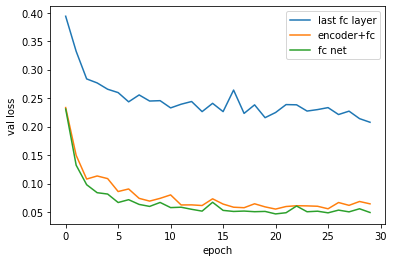

In [ ]:
PlotVal(vl_cae_cls1, vl_cae_cls2, vl_cae_cls3) #, 'last layer cls','pretrain encoder+cls', 'encoder+cls arhi')

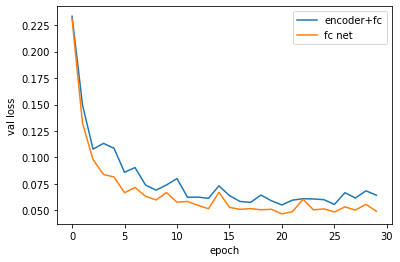

In [ ]:
x = range(30)
plt.plot(x, vl_cae_cls2, label = 'encoder+fc')
plt.plot(x, vl_cae_cls3, label = 'fc net')
plt.xlabel('epoch')
plt.ylabel('val loss')
plt.legend()
plt.show()

#Добавление аугментаций (используем прошлые датасеты)

In [ ]:
augConvAE = CN_AE()

In [ ]:
params_CAE = list(augConvAE.encoder.parameters()) + list(augConvAE.decoder.parameters())

optimizer = optim.Adam(params_CAE, lr=1e-3)# обучение кодирование декодирования
criterion = nn.MSELoss()

In [ ]:
tl_cae, vl_cae = [], [] # change to view vl_cae_cls1 
tmp_loss = float('inf')
for epoch in range(epochs):
    print('\nEpoch {:} / {:}'.format(epoch + 1, epochs)+' ################')
    train_loss = conv_train(augConvAE, aug_train_loader)
    val_loss = conv_evaluate(augConvAE, aug_val_loader)
    if val_loss < tmp_loss:
        tmp_loss = val_loss
        t.save(augConvAE.state_dict(), '/content/drive/MyDrive/AutoEncoders/' + 'aug_ConvAE' + '.pt')
        t.save(augConvAE.state_dict(),'aug_ConvAE' + '.pt')
        print(epoch+1)
    tl_cae.append(train_loss)
    vl_cae.append(val_loss)
    print(f'    train loss: {train_loss}, val loss: {val_loss}')


Epoch 1 / 30 ################
1
    train loss: 0.267169839833551, val loss: 0.12029392291096193

Epoch 2 / 30 ################
2
    train loss: 0.09942020874117952, val loss: 0.08954917620631712

Epoch 3 / 30 ################
3
    train loss: 0.08184189410389536, val loss: 0.07896955301867256

Epoch 4 / 30 ################
4
    train loss: 0.07222641703417844, val loss: 0.06904038258745701

Epoch 5 / 30 ################
5
    train loss: 0.0654339250320059, val loss: 0.0633939081166364

Epoch 6 / 30 ################
6
    train loss: 0.06061096183593621, val loss: 0.06006432079438922

Epoch 7 / 30 ################
7
    train loss: 0.0573091122995862, val loss: 0.05661462832100784

Epoch 8 / 30 ################
8
    train loss: 0.05489889752415135, val loss: 0.054532000252717656

Epoch 9 / 30 ################
9
    train loss: 0.05288263690441161, val loss: 0.05288570921255063

Epoch 10 / 30 ################
10
    train loss: 0.05111201635330839, val loss: 0.05166818790986568

E

In [ ]:
augConvAE.load_state_dict(t.load('/content/aug_ConvAE.pt'))

<All keys matched successfully>

In [ ]:
augConvAE.to(device)

#Сверточынй AE-> classifier (учим последний слой)

In [ ]:
params_CAE_cls = list(augConvAE.classifier1.parameters())
optimizer = optim.Adam(params_CAE_cls, lr=1e-3)# обучение кодирование декодирования
criterion = nn.CrossEntropyLoss()

In [ ]:
tl_augcae_cls1, vl_augcae_cls1 = train_cls_cn(augConvAE, aug_train_loader, aug_val_loader, aug=True)

1
epoch : 1/30
    loss train = 0.9017250130853385, loss val = 0.42331144854992253
2
epoch : 2/30
    loss train = 0.5383228496136263, loss val = 0.38136722317224814
epoch : 3/30
    loss train = 0.5022513152998122, loss val = 0.387038071510158
4
epoch : 4/30
    loss train = 0.479390795654653, loss val = 0.3613844738353657
5
epoch : 5/30
    loss train = 0.4682233477263804, loss val = 0.3392592091349107
epoch : 6/30
    loss train = 0.4700318843202518, loss val = 0.3588143196664279
epoch : 7/30
    loss train = 0.45882618473009074, loss val = 0.378568012503129
epoch : 8/30
    loss train = 0.45492286160778816, loss val = 0.3659227045276497
epoch : 9/30
    loss train = 0.44663413292001886, loss val = 0.3615369957081879
10
epoch : 10/30
    loss train = 0.4454817646909553, loss val = 0.33351126784765267
11
epoch : 11/30
    loss train = 0.4412326502525593, loss val = 0.3255806345068201
12
epoch : 12/30
    loss train = 0.43935594267552464, loss val = 0.3242399568987798
epoch : 13/30
  

In [ ]:
augConvAE.load_state_dict(t.load('/content/aug_ConvAE_cls1.pt'))

<All keys matched successfully>

micro: 0.9168
macro: 0.9160258289015406
accuracy: 0.9168
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.98      0.97      0.98      1135
           2       0.90      0.91      0.91      1032
           3       0.91      0.90      0.90      1010
           4       0.92      0.89      0.91       982
           5       0.91      0.87      0.89       892
           6       0.95      0.93      0.94       958
           7       0.95      0.89      0.92      1028
           8       0.87      0.89      0.88       974
           9       0.84      0.93      0.88      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



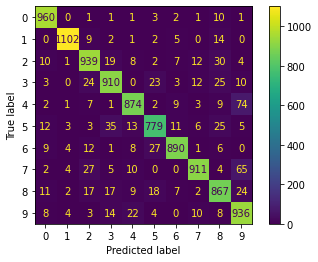

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

true, pred = get_true_tst(), get_pred_tst_cn(augConvAE)

print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))

#Сверточный AE-> classifier (учим pretrained encoder + classifier)

In [ ]:
params_CAE_cls = list(augConvAE.encoder.parameters()) + list(augConvAE.classifier2.parameters())
optimizer = optim.Adam(params_CAE_cls, lr=1e-3)# обучение кодирование декодирования
criterion = nn.CrossEntropyLoss()

In [ ]:
tl_augcae_cls2, vl_augcae_cls2 = train_cls_cn(augConvAE, aug_train_loader, aug_val_loader, False, True)

1
epoch : 1/30
    loss train = 0.92292857467366, loss val = 0.3466721180873581
2
epoch : 2/30
    loss train = 0.38676882415171476, loss val = 0.19661147684990604
3
epoch : 3/30
    loss train = 0.2771180620812394, loss val = 0.14822056125613708
4
epoch : 4/30
    loss train = 0.23216728507862677, loss val = 0.12102552284073981
5
epoch : 5/30
    loss train = 0.20850837686101495, loss val = 0.10625669646630936
6
epoch : 6/30
    loss train = 0.19250985663717665, loss val = 0.1052011845138254
7
epoch : 7/30
    loss train = 0.18050827832935412, loss val = 0.09026445365876337
8
epoch : 8/30
    loss train = 0.17547835563035571, loss val = 0.08854228637735301
9
epoch : 9/30
    loss train = 0.16358131122634845, loss val = 0.08032086465649213
10
epoch : 10/30
    loss train = 0.16133353560019636, loss val = 0.07567400220027075
11
epoch : 11/30
    loss train = 0.15516233259378492, loss val = 0.07150406894993179
epoch : 12/30
    loss train = 0.14934212552464526, loss val = 0.0737135639661

In [ ]:
augConvAE.load_state_dict(t.load('/content/aug_ConvAE_cls2.pt'))

<All keys matched successfully>

micro: 0.9858
macro: 0.9857473657476012
accuracy: 0.9858
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



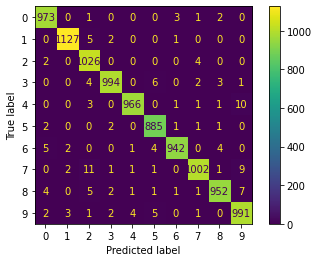

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

true, pred = get_true_tst(), get_pred_tst_cn(augConvAE, False)

print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))

#CNNet

In [ ]:
cn_cl = CNNet().to(device)
optimizer = optim.Adam(cn_cl.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
tl_augcae_cls3, vl_augcae_cls3 = train_cls_cn3(cn_cl, aug_train_loader, aug_val_loader, True)


1
epoch : 1/30
    loss train = 0.8216433246879626, loss val = 0.25805485984192617
2
epoch : 2/30
    loss train = 0.3330515898630747, loss val = 0.16546597420179013
3
epoch : 3/30
    loss train = 0.25629205298621943, loss val = 0.12896834955185274
4
epoch : 4/30
    loss train = 0.22102121639129757, loss val = 0.11490935579979722
5
epoch : 5/30
    loss train = 0.20141083368902926, loss val = 0.10434926471000985
6
epoch : 6/30
    loss train = 0.19251138385375746, loss val = 0.09792042455246931
7
epoch : 7/30
    loss train = 0.1807234773359945, loss val = 0.09200465061430689
8
epoch : 8/30
    loss train = 0.1708219065747755, loss val = 0.08581686047822402
epoch : 9/30
    loss train = 0.16693963063761708, loss val = 0.08910992851221486
10
epoch : 10/30
    loss train = 0.1610598304330388, loss val = 0.08058357937261462
11
epoch : 11/30
    loss train = 0.16044590386855023, loss val = 0.07965388997233933
epoch : 12/30
    loss train = 0.1526702046203796, loss val = 0.080569189206897

In [ ]:
cn_cl.load_state_dict(t.load('/content/aug_ConvAE_cls3.pt'))

<All keys matched successfully>

micro: 0.9857
macro: 0.9855967733080953
accuracy: 0.9857
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



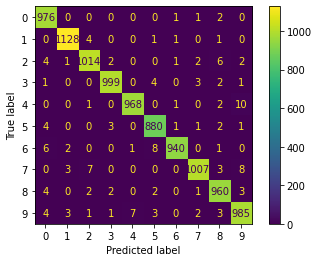

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

true, pred = get_true_tst(), get_pred_tst_cn3(cn_cl)
print(f"micro: {f1_score(true, pred, average='micro')}\nmacro: {f1_score(true, pred, average='macro')}")
print(f'accuracy: {accuracy_score(true, pred)}')

print(ConfusionMatrixDisplay.from_predictions(true, pred))
print(classification_report(true, pred, target_names=[str(i) for i in range(10)]))

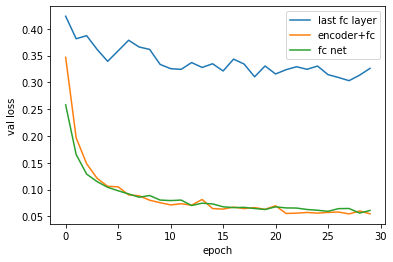

In [ ]:
PlotVal(vl_augcae_cls1, vl_augcae_cls2, vl_augcae_cls3)

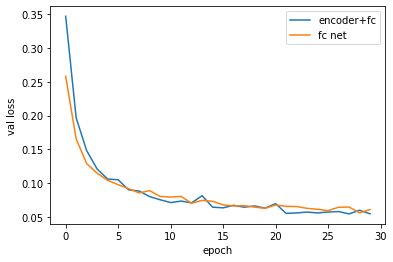

In [ ]:
x = range(30)
plt.plot(x, vl_augcae_cls2, label = 'encoder+fc')
plt.plot(x, vl_augcae_cls3, label = 'fc net')
plt.xlabel('epoch')
plt.ylabel('val loss')
plt.legend()
plt.show()

In [ ]:
sum(vl_augcae_cls2) - sum(vl_augcae_cls3) # с аугментациями (суммарный валидационный лосс предобученного энкодера+слой классификиции) - (суммарный валидационный лосс модели, с архитектурой энкодера+слой классификиции)

0.07239240681851244

In [ ]:
sum(vl_cae_cls2) - sum(vl_cae_cls3) # (суммарный валидационный лосс предобученного энкодера+слой классификиции) - (суммарный валидационный лосс модели, с архитектурой энкодера+слой классификиции)

NameError: ignored